<a name='1'></a>
## 1.  Import Packages

We'll first import all the packages that we need. 



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle 
%matplotlib inline

import os
from sklearn.utils import shuffle 
import random
from skimage import draw
import pandas as pd
from scipy import ndimage
import cv2 

from PIL import Image

import seaborn as sns
sns.set()

from sklearn.utils import shuffle 

#%matplotlib notebook
np.set_printoptions(suppress=True)

<a name='1.1'></a>
### 1.1  Useful functions

In [2]:
os.chdir("../Utils_J")

from Utils_Magnetic_methods import * # all the functions created that will be useful 

os.chdir("../")

<a name='2.1'></a>
### 2.1  Model grid



In [3]:
grid_caracteristic = {
    
    'zmax': 100, # Total number of grid lines
    'map_lenght': 25 # [m] Our grid will be between (-map_lenght,map_lenght) because our anomalie is centered in (0,0)
}

zmax = grid_caracteristic['zmax']
map_lenght = grid_caracteristic['map_lenght']

X, Y = grid(zmax, map_lenght) # X and Y in [meters]

print(f'X array shape: {X.shape}')
print(f'Y array shape: {Y.shape}')
print(f'Cell lenght: {(map_lenght*2)/zmax}')

X array shape: (100, 1)
Y array shape: (1, 100)
Cell lenght: 0.5


<a name='2.2'></a>
### 2.2 Latitudes



In [4]:
lat_dict = {
    
    'lat_min': 0, #[°]
    'lat_max': 120, #[°]
    'lat_frequency': 300, #[°]
    
} 

lat_array, lat_array_rad, I = latitudes_array(lat_dict['lat_min'], lat_dict['lat_max'], lat_dict['lat_frequency'])

print(f'Latitudes: {lat_array} [°]') # °
print(f'Latitudes: {np.round(lat_array_rad, decimals=2)} [rad]') # °
print(f'Inclinaison: {np.round(I, decimals=2)} [rad]')



Latitudes: [30] [°]
Latitudes: [0.52] [rad]
Inclinaison: [0.86] [rad]


<a name='3'></a>
## 3.  Defining anomalies physical characteristics



In [5]:
r_v_d_dict = {
    
    'Br': 47000, #Champ local(nT)
    'ksi': 0.1, 
    'r_min': 0.12, #[meters]
    'r_max': 0.18, #[meters]
    'r_frequency':10, #[meters]
    'h_min': 1.2, #[meters]
    'h_max': 1.8, #[meters]
    'h_frequency': 10, #[meters]
    'h_capteur': 0.5#hauteur du capteur [meters]
    
}

Br = r_v_d_dict['Br']
ksi = r_v_d_dict['ksi']
r_min = r_v_d_dict['r_min']
r_max = r_v_d_dict['r_max']
r_frequency = r_v_d_dict['r_frequency']
h_min = r_v_d_dict['h_min']
h_max = r_v_d_dict['h_max']
h_frequency = r_v_d_dict['h_frequency'] 
h_capteur = r_v_d_dict['h_capteur'] 



r_array, V_array, h_array, h_capteur, n_examples, Parameters_array, m = r_V_h_array(r_min, r_max, r_frequency,
                                                                                    h_min, h_max, h_frequency, 
                                                                                    h_capteur, zmax, Br, ksi)

print(f'Radius: {np.round(r_array[:], decimals=3)} [meters]') # Last 3 examples

print(f'Volume: {V_array[:]} [m^3]') # Last 3 examples

print(f'Number of V: {V_array.shape[0]}') # Last 3 examples

print("---------------------------------------------")

print(f'Depth: {np.round(h_array[:], decimals = 2)} [meters]') # Last 3 examples

print(f'Number of h: {h_array.shape[0]}') # Last 3 examples

print("---------------------------------------------")

print(f'Sensor height: {h_capteur} [meters]') 

print("---------------------------------------------")

print(f'Number of examples: {n_examples}')
print(f'Parameters array shape: {Parameters_array.shape} 1st channel Volume, 2nd channel Depth') # 2 channels (1- Volume, 2- Depth)
print(f'Dipole magnetic moment: {m[-3:]} [A.m^2]')




Radius: [0.12] [meters]
Volume: [0.007] [m^3]
Number of V: 1
---------------------------------------------
Depth: [1.2] [meters]
Number of h: 1
---------------------------------------------
Sensor height: 0.5 [meters]
---------------------------------------------
Number of examples: 1
Parameters array shape: (1, 2) 1st channel Volume, 2nd channel Depth
Dipole magnetic moment: [32.9] [A.m^2]


<a name='4'></a>
## 4.  Creating X and Y array 



<a name='4.1'></a>
### 4.1 Raw data (before data augmetation)



In [6]:
def X_array_raw(Br, m, I, X, Y, h, N_lat, examples, zmax, n_parameters, lat_array_rad, Parameters_array):

    X_array_raw = np.zeros((N_lat, examples, zmax, zmax)) # Array with magnetic induction values

    Parameters_array_raw = np.zeros((N_lat, examples, n_parameters)) # Array with volume and depth values

    i = 0

    for i_lat_rad in lat_array_rad:

        Anomalie = None

        r = np.sqrt(np.add(np.add(X**2, Y**2), (h**2).reshape(h.shape[0], 1, 1)))

        costeta = np.divide(((X * np.cos(I[i])) - (np.multiply(h.reshape(h.shape[0], 1, 1), np.sin(I[i])))), r)

        Anomalie = np.outer(m.reshape(m.shape[0],1,1), np.divide(3*(costeta**2) - 1, r**3)).reshape((examples,zmax,zmax))

        X_array_raw[i, :, :, :] = Anomalie

        Parameters_array_raw[i,:,:] = Parameters_array[:,:]

        i += 1
        
    return X_array_raw, Parameters_array_raw



In [7]:
### X_data array, Calculating Induction magnétique de l'Anomalie [nT] ###

X_Y_array_dict = {
    
    'N_latitudes': lat_array.shape[0], # Number of latitudes
    'N_parameters': Parameters_array.shape[1] # Number of parameters
}

N_latitudes = X_Y_array_dict["N_latitudes"]
N_parameters = X_Y_array_dict["N_parameters"]

X_data_array_raw, Parameters_array_raw = X_array_raw(Br, m, I, X, Y, h_array, N_latitudes, 
                                                     n_examples, zmax, N_parameters, 
                                                     lat_array_rad, Parameters_array)


print(f'X array raw shape: {X_data_array_raw.shape}')
print(f'Parameters array raw shape: {Parameters_array_raw.shape}')



X array raw shape: (1, 1, 100, 100)
Parameters array raw shape: (1, 1, 2)


<a name='4.5'></a>
### 4.5 Creating X array (counting number of dipoles and data augmentation)



In [8]:
def X_array(N_dipoles_f, N_parameters_f, dist_min_i, X_data_pad, Parameters_array_raw, rotation, h_array):

    #### Number of dipoles ###

    N_dipoles = N_dipoles_f
    N_parameters = N_parameters_f
    N_h = h_array.shape[0]
    
    ##########################
    
    h_counting = np.arange(0, N_h, 1)

    h_idx = np.tile(h_counting, N_h)
    
    ##########################

    N_lat = X_data_pad.shape[0]
    n_examples = X_data_pad.shape[1]
    zmax = int(X_data_pad.shape[2])
    border_o = int(zmax/2)
    
    ##########################
    
    conversion = (2*map_lenght)/zmax
    
    ##########################
    
    dist_min = dist_min_i / conversion
    
    ##########################

    X_data = np.zeros((N_lat, N_dipoles, n_examples, zmax, zmax))
    Parameters = np.zeros((N_lat, N_dipoles, n_examples, N_dipoles*N_parameters ))
    Position = np.zeros((N_lat, N_dipoles, n_examples , N_dipoles*2))

    No_pad_left = int((zmax) - zmax/2)
    No_pad_right = int((zmax) + zmax/2)

    Position_array_to_add = np.zeros((N_lat,N_dipoles,n_examples, 2))
    
    w_in = 1

    for i_lat in range(0, N_lat, 1):
        
        for n_dipoles_i in range(0, N_dipoles, 1):

            for i_n_examples in range(0, n_examples, 1):
                
                #corr_min = int((zmax/2)-((box_confidence + ((h_idx[i_n_examples])*3))//2))
                #corr_max = int((zmax/2)+((box_confidence + ((h_idx[i_n_examples])*3))//2))
                                
                limit = (zmax/2) - 2
                dist_min_f = int(5 + (h_idx[i_n_examples]*1.5))
                

                if n_dipoles_i == 0:
                    
                    ##########################        
                    
                    position_x = 0
                    position_y = 0
                    
                    Position_array_to_add[i_lat, n_dipoles_i, i_n_examples, 0] = position_x + zmax/2
                    Position_array_to_add[i_lat, n_dipoles_i, i_n_examples, 1] = position_y + zmax/2
                    
                    ##########################
                    
                    if i_lat == 3:
                        
                        rot_n = 0 
                        
                    else:
                    
                        rot_n = random.choice(rotation)
                    
                    img = X_data_pad[i_lat,i_n_examples,:,:]
                        
                    X_array_rot = ndimage.rotate(img, rot_n, axes=(0,1), reshape=False)
                    
                    X_data_padded = cv2.copyMakeBorder(X_array_rot, border_o, border_o, border_o, border_o, 0)
                    
                    X_data_x = np.roll(X_data_padded, position_x, axis=1)
                    X_data_y = np.roll(X_data_x, position_y, axis=0)
                    
                    X_array_os = X_data_y[No_pad_left:No_pad_right,No_pad_left:No_pad_right]
                                            
                    X_data[i_lat,n_dipoles_i,i_n_examples,:,:] = X_array_os

                    ##########################
                    
                    Parameters[i_lat,n_dipoles_i:,i_n_examples,n_dipoles_i*N_parameters] = rot_n
                    Parameters[i_lat,n_dipoles_i:,i_n_examples,(n_dipoles_i*N_parameters)+1:(n_dipoles_i*N_parameters)+3] = np.round(Parameters_array_raw[i_lat,i_n_examples,:], 3)

                    ##########################
                    
                    Position[i_lat,n_dipoles_i:,i_n_examples,(n_dipoles_i)*2:(n_dipoles_i+1)*2] = np.round(Position_array_to_add[i_lat,n_dipoles_i,i_n_examples,:], 0)
                
                else:
                    
                    while w_in == 1:
                        
                        in_a = 0

                        position_x_0 = random.randint(-limit, -dist_min_f)
                        position_x_1 = random.randint(dist_min_f, limit)

                        position_x = random.choice([position_x_0, position_x_1])

                        position_y_0 = random.randint(-limit, -dist_min_f)
                        position_y_1 = random.randint(dist_min_f, limit)

                        position_y = random.choice([position_y_0, position_y_1])

                        X_c = ((position_x) - (Position_array_to_add[i_lat,:,i_n_examples,0] - zmax/2))

                        Y_c = ((position_y) - (Position_array_to_add[i_lat,:,i_n_examples,1] - zmax/2))

                        distance = np.sqrt(X_c**2 + Y_c**2)
                    
                        if np.all(dist_min < distance):
                            
                            break

                        else:
                            
                            if in_a >150:
                                
                                print("Looping forever?")
                            
                            in_a += 1

                            continue
                                        
                    Position_array_to_add[i_lat, n_dipoles_i, i_n_examples, 0] = position_x + zmax/2
                    Position_array_to_add[i_lat, n_dipoles_i, i_n_examples, 1] = position_y + zmax/2
                                        
                    ##########################
                    
                    if i_lat == 3:
                        
                        rot_n = 0 
                        
                    else:
                    
                        rot_n = random.choice(rotation)
                    
                    img = X_data_pad[i_lat,i_n_examples,:,:]
                        
                    X_array_rot = ndimage.rotate(img, rot_n, axes=(0,1), reshape=False)
                    
                    X_data_padded = cv2.copyMakeBorder(X_array_rot, border_o, border_o, border_o, border_o, 0)
                    
                    X_data_x = np.roll(X_data_padded, position_x, axis=1)
                    X_data_y = np.roll(X_data_x, position_y, axis=0)
                    
                    X_array_os = X_data_y[No_pad_left:No_pad_right,No_pad_left:No_pad_right]

                    X_data[i_lat,n_dipoles_i,i_n_examples,:,:] = X_data[i_lat,n_dipoles_i-1,i_n_examples,:,:] + X_array_os
                    
                    

                    ##########################
                    
                    Parameters[i_lat,n_dipoles_i:,i_n_examples,n_dipoles_i*N_parameters] = rot_n
                    Parameters[i_lat,n_dipoles_i:,i_n_examples,(n_dipoles_i*N_parameters)+1:(n_dipoles_i*N_parameters)+3] = np.round(Parameters_array_raw[i_lat,i_n_examples,:], 3)

                    ##########################
                    
                    Position[i_lat,n_dipoles_i:,i_n_examples,(n_dipoles_i)*2:(n_dipoles_i+1)*2] = np.round(Position_array_to_add[i_lat,n_dipoles_i,i_n_examples,:], 0)
                                                        
        
    return X_data, Parameters, Position

In [9]:
#### Data augmentation ####

N_models = 1

### Number of dipoles and min distance between dipoles ###

N_parameters_f = 3 #Latitude, Depth, Radius
N_dipoles_f = 40

##########################

dist_min_i = 5 # meters

##########################

rotation = np.arange(0, 180, 30)

##########################

X_data_f = np.zeros((N_models, N_latitudes, N_dipoles_f, n_examples, zmax, zmax))
Parameters_f = np.zeros((N_models, N_latitudes, N_dipoles_f, n_examples, N_parameters_f*N_dipoles_f))
Position_f = np.zeros((N_models, N_latitudes, N_dipoles_f, n_examples, 2*N_dipoles_f))

for i_n_models in range(N_models):

    X_data_f[i_n_models,:,:,:,:], Parameters_f[i_n_models,:,:,:,:], Position_f[i_n_models,:,:,:,:] = X_array(N_dipoles_f, N_parameters_f, dist_min_i, X_data_array_raw, Parameters_array_raw , rotation, h_array)
    
    print(f"Model: {i_n_models+1} ready")
    
    

Model: 1 ready


In [10]:
X_data_f = np.moveaxis(X_data_f, 1, 0)
Parameters_final = np.moveaxis(Parameters_f, 1, 0)
Position_f = np.moveaxis(Position_f, 1, 0)

print(f"X_data shape: {X_data_f.shape}")
print(f"Parameters shape: {Parameters_final.shape}")
print(f"Position shape: {Position_f.shape}")


X_data shape: (1, 1, 40, 1, 100, 100)
Parameters shape: (1, 1, 40, 1, 120)
Position shape: (1, 1, 40, 1, 80)


### rearranging database shape

In [11]:
def rearrange_dipoles(X_data_array, Parameters_f, Position_f):
    
    X_data_array_final = X_data_array.reshape(X_data_array.shape[0] * X_data_array.shape[1]*X_data_array.shape[2]*X_data_array.shape[3]
                                              ,X_data_array.shape[4], X_data_array.shape[5])

    Parameters_final = Parameters_f.reshape(Parameters_f.shape[0] * Parameters_f.shape[1]*Parameters_f.shape[2]*Parameters_f.shape[3],
                                            Parameters_f.shape[4])
    
    Position_final = Position_f.reshape(Position_f.shape[0] * Position_f.shape[1]*Position_f.shape[2]*Position_f.shape[3],
                                        Position_f.shape[4])
    
    return X_data_array_final, Parameters_final, Position_final




In [12]:
X_array_final, Parameters_f, Position_f = rearrange_dipoles(X_data_f, Parameters_final, Position_f)

In [13]:
print(f'X_data shape:{X_array_final.shape}') 
print(f'Y_par shape: {Parameters_f.shape}')
print(f'Y_pos shape: {Position_f.shape}')


X_data shape:(40, 100, 100)
Y_par shape: (40, 120)
Y_pos shape: (40, 80)


In [14]:
X_array_to_test = X_array_final[-1,:,:].reshape(1,100,100,1)

Parameters_test = Parameters_f[-1:,:]

Position_test = Position_f[-1:,:]

<a name='4.7'></a>
### 4.7 X,Y data visualization



Dipole: 1, Xcenter: 0, Ycenter: 0, Rotation: 120, Radius: 0.12 m, Depth: 1.2 m
Dipole: 2, Xcenter: -2, Ycenter: 13, Rotation: 150, Radius: 0.12 m, Depth: 1.2 m
Dipole: 3, Xcenter: -8, Ycenter: -8, Rotation: 90, Radius: 0.12 m, Depth: 1.2 m
Dipole: 4, Xcenter: -2, Ycenter: -8, Rotation: 30, Radius: 0.12 m, Depth: 1.2 m
Dipole: 5, Xcenter: 13, Ycenter: 10, Rotation: 60, Radius: 0.12 m, Depth: 1.2 m
Dipole: 6, Xcenter: 11, Ycenter: -8, Rotation: 60, Radius: 0.12 m, Depth: 1.2 m
Dipole: 7, Xcenter: -10, Ycenter: -21, Rotation: 0, Radius: 0.12 m, Depth: 1.2 m
Dipole: 8, Xcenter: 2, Ycenter: 24, Rotation: 120, Radius: 0.12 m, Depth: 1.2 m
Dipole: 9, Xcenter: -16, Ycenter: -14, Rotation: 0, Radius: 0.12 m, Depth: 1.2 m
Dipole: 10, Xcenter: -17, Ycenter: 12, Rotation: 0, Radius: 0.12 m, Depth: 1.2 m
Dipole: 11, Xcenter: 17, Ycenter: -18, Rotation: 90, Radius: 0.12 m, Depth: 1.2 m
Dipole: 12, Xcenter: -24, Ycenter: -13, Rotation: 0, Radius: 0.12 m, Depth: 1.2 m
Dipole: 13, Xcenter: 20, Ycenter:

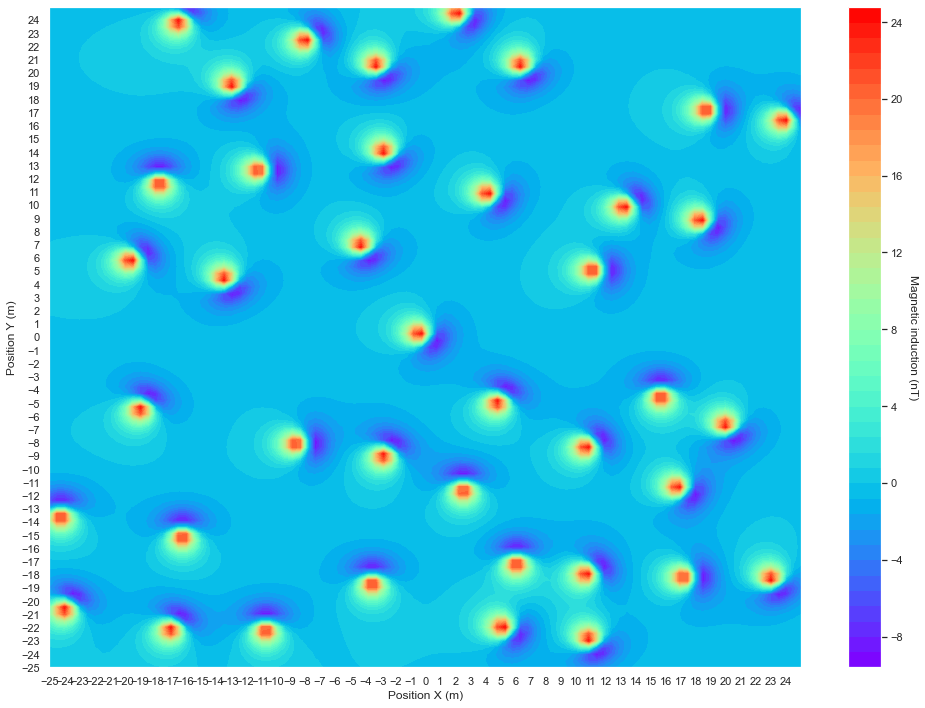

In [15]:
height_2 = 10
width_2 = 14

##############################

plt.figure(figsize=(width_2, height_2))

X = np.linspace(-map_lenght, map_lenght, zmax)
Y = np.linspace(-map_lenght, map_lenght, zmax)

parameters = Parameters_f[-1,:]

model_to_plot_l = int(np.random.randint(0, X_array_final.shape[1], 1))

plt.contourf(X, Y, X_array_final[-1,:,:], levels = 50, cmap='rainbow')
plt.xlabel('Position X (m)')
plt.xticks(np.arange(-25, 25, step=1))
plt.ylabel('Position Y (m)')
plt.yticks(np.arange(-25, 25, step=1))
clb = plt.colorbar()
clb.set_label('Magnetic induction (nT)', labelpad=15, y=0.5, rotation=270)

for par_i in range(N_dipoles_f):
    
    print(f'Dipole: {par_i+1}, Xcenter: {int(((Position_test[0,0+(par_i*2)])-zmax/2)/2)}, Ycenter: {int(((Position_test[0,1+(par_i*2)])-zmax/2)/2)}, Rotation: {int(Parameters_test[0,0+((par_i*3))])}, Radius: {Parameters_test[0,1+((par_i*3))]} m, Depth: {Parameters_test[0,2+((par_i*3))]} m')
    
    
print('---'*10)

plt.tight_layout()
    

<a name='4.10'></a>
### 4.10 h5py file creation



In [16]:
import h5py

def create_hdf5_train_dev_test(path, file_name, X_array):
 
    
    hdf5_path = path + file_name
    
    hdf5_file = h5py.File(hdf5_path, mode='w')
    hdf5_file.create_dataset("X_array", X_array.shape)
    hdf5_file["X_array"][:,:,:,:] = X_array[:,:,:,:]
    
                                               
    hdf5_file.close()  

In [17]:
path = "/Users/juliojose/Desktop/Doctorat_backup/YOLO_application/custom_functions/data/h5_files/"
file_name = f'V11_DB_test.hdf5'

create_hdf5_train_dev_test(path, file_name, X_array_to_test)


